# Zadanie 6 - Sztuczne sieci neuronowe


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski [1.5 pkt]
4. Jakość kodu [0.5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)

# Implementacja


In [1]:
from typing import List
from abc import ABC, abstractmethod
import numpy as np

class Layer(ABC):
    def __init__(self):
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def backward(self, output_error_derivative):
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, "Given learning_rate is larger than 1"
        assert learning_rate > 0, "Given learning_rate is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.random.randn(output_size)

    def forward(self, x:np.array):
        self.input = x
        return np.dot(x, self.weights.T) + self.biases

    def backward(self, output_error_derivative):
        input_error_derivative = np.dot(output_error_derivative, self.weights)
        weights_error_derivative = np.dot(output_error_derivative.T, self.input) / self.input.shape[0]
        biases_error_derivative = np.sum(output_error_derivative, axis=0)  / self.input.shape[0]
        
        self.weights -= self.learning_rate * weights_error_derivative
        self.biases -= self.learning_rate * biases_error_derivative
        
        return input_error_derivative

class Tanh(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.output = np.tanh(x)
        return self.output

    def backward(self, output_error_derivative):
        return (1 - np.power(self.output, 2)) * output_error_derivative

class Loss:
    def __init__(self, loss_function, loss_function_derivative):
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, y_pred:np.ndarray, y_true:np.ndarray)->np.ndarray:
        return self.loss_function(y_pred, y_true)

    def loss_derivative(self, y_pred:np.ndarray, y_true:np.ndarray)->np.ndarray:
        return self.loss_function_derivative(y_pred, y_true)

class Network:
    def __init__(self, layers:List[Layer], loss:Loss, learning_rate:float):
        self.loss = loss
        self.layers = layers
        self.learning_rate = learning_rate
        for layer in self.layers:
            layer.learning_rate = learning_rate

    def __call__(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def fit(self, x_train, y_train, epochs):
        for i in range(epochs):
            output = self.__call__(x_train)
            error = self.loss.loss_derivative(y_train, output)
            for layer in reversed(self.layers):
                error = layer.backward(error)


In [2]:
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return np.power(y_true-y_pred, 2)

def mse_derivative(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return 2*(y_pred-y_true)

# Eksperymenty
Pobieranie i normalizacja zbioru MNIST

In [3]:
from sklearn.datasets import load_digits

digits = load_digits()

pixels = np.array(digits.data) / 16
numbers = np.array(digits.target)

one_hot_numbers = np.zeros((numbers.size, 10))
one_hot_numbers[np.arange(numbers.size), numbers] = 1

In [4]:
def get_accuracy(y_pred, y_test):
    good = 0
    for j in range(y_test.size):
        if y_pred[j] == y_test[j]:
            good+=1
    return good/y_test.size

In [18]:
from sklearn.model_selection import train_test_split

def test_network(layers, epochs, seeds, verbose):
    accuracies = []
    errors = []
    for j in range(seeds):
        np.random.seed(j*j)
        pixels_train, pixels_test, numbers_train, numbers_test, one_hot_numbers_train, one_hot_numbers_test = \
            train_test_split(pixels, numbers, one_hot_numbers, test_size=0.2)

        loss = Loss(mse, mse_derivative)
        net = Network(layers, loss, 0.05)

        net_accuracy = []
        net_error = []
        for i in range(epochs//100):
            net.fit(pixels_train, one_hot_numbers_train, 100)
            a = net(pixels_test)
            accuracy = get_accuracy(np.argmax(a, axis=1), numbers_test)
            error = np.average(np.abs(mse_derivative(one_hot_numbers_test, a)))
            if verbose:
                print(f"{(i+1)*100}:\tA: {accuracy:.4f},\tE:{error:.4f}")
            net_accuracy.append(accuracy)
            net_error.append(error)
        accuracies.append(net_accuracy)
        errors.append(net_error)
    epochs = [x for x in range(100, epochs+1, 100)]
    return np.array(epochs), np.array(accuracies), np.array(errors)

<B>Testowanie sieci 3, 2 i 1 warstwowej

In [6]:
from matplotlib import pyplot as plt

EPOCHS = 20000
SEEDS = 3
VERBOSE = False

In [7]:
layers3 = [FullyConnected(64, 32), Tanh(), FullyConnected(32,32), Tanh(), FullyConnected(32,10), Tanh()]
epochs3, accuracies3, errors3 = test_network(layers3, EPOCHS, SEEDS, VERBOSE)
accuracies3 = np.average(accuracies3, axis=0)
errors3 = np.average(errors3, axis=0)

In [19]:
layers2 = [FullyConnected(64, 32), Tanh(), FullyConnected(32,10), Tanh()]
epochs2, accuracies2, errors2 = test_network(layers2, EPOCHS, SEEDS, VERBOSE)
accuracies2 = np.average(accuracies2, axis=0)
errors2 = np.average(errors2, axis=0)

In [12]:
layers1 = [FullyConnected(64, 10), Tanh()]
epochs1, accuracies1, errors1 = test_network(layers1, EPOCHS, SEEDS, VERBOSE)
accuracies1 = np.average(accuracies1, axis=0)
errors1 = np.average(errors1, axis=0)

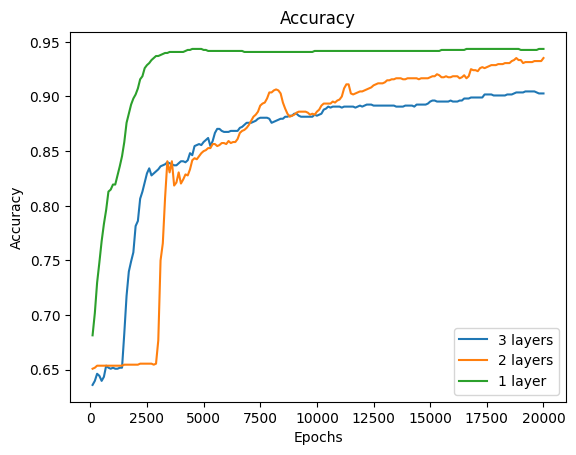

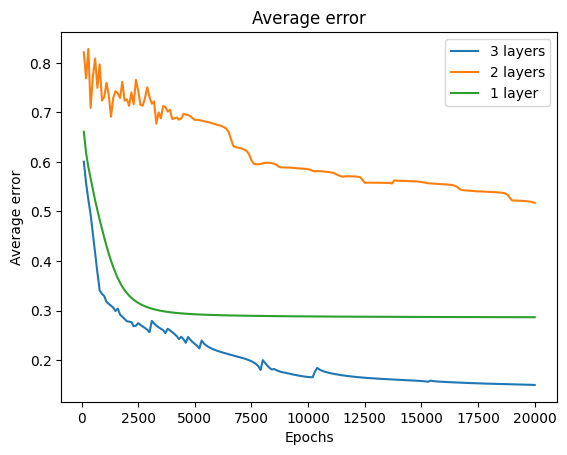

In [20]:
plt.plot(epochs3, accuracies3, label='3 layers')
plt.plot(epochs2, accuracies2, label='2 layers')
plt.plot(epochs1, accuracies1, label='1 layer')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(epochs3, errors3, label='3 layers')
plt.plot(epochs2, errors2, label='2 layers')
plt.plot(epochs1, errors1, label='1 layer')
plt.xlabel("Epochs")
plt.ylabel("Average error")
plt.title("Average error")
plt.legend()
plt.show()

<b> Bramka XOR

In [ ]:
x = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[1,0],[0,1],[0,1],[1,0]])

np.random.seed(20)
layers = [FullyConnected(2, 2), Tanh(), FullyConnected(2, 2), Tanh()]
loss = Loss(mse, mse_derivative)
net = Network(layers, loss, 0.1)
net.fit(x, y, 10000)

predicted = net(x)

print("Layer 1")
print("Weights:")
print(layers[0].weights)
print("Biases:")
print(layers[0].biases)

output1 = layers[0].forward([[1,0]])
print("Output:")
print(output1)
output1tanh = layers[1].forward(output1)
print("Tanh:")
print(output1tanh)

print('')
print("Layer 2")
print("Weights:")
print(layers[2].weights)
print("Biases:")
print(layers[2].biases)

output2 = layers[2].forward(output1tanh)
print("Output:")
print(output2)
output2tanh = layers[3].forward(output2)
print("Tanh:")
print(output2tanh)
  



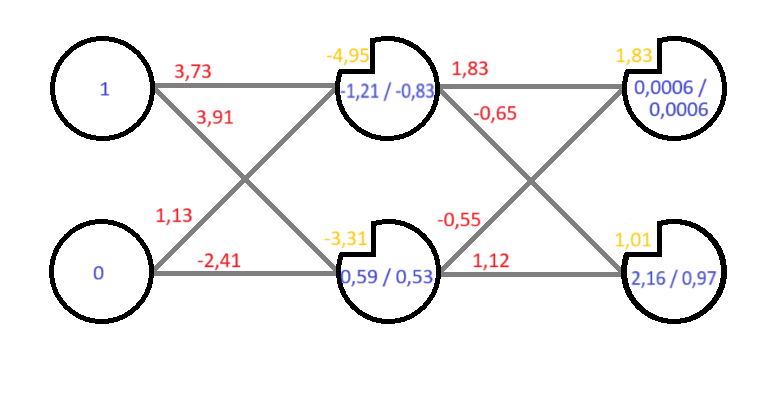

# Wnioski

Liczba warstw sieci neuronowej jest zależna od problemu który chcemy rozwiązać, dla klasyfikacji na zbiorze MNIST udało się osiągnąć wysoką precyzję nawet na sieci jednowarstwowej.

Mniejsza liczba warstw powoduje szybsze uczenie się sieci, ponieważ jest mniej parametrów do optymalizacji, jednak więcej parametrów może pozwolić na lepsze dopasowanie się do zbioru.

Zbyt duża liczba epok i warstw może spowodować przeuczenie się sieci.